In [1]:
packages <- c("ggplot2", "dplyr", "patchwork")
for (pkg in packages) {
    suppressPackageStartupMessages(
        suppressWarnings(
            library(
                pkg,
                character.only = TRUE,
                quietly = TRUE,
                warn.conflicts = FALSE
            )
        )
    )
}

In [2]:
umap_file_path <- file.path(
    "../../../3.generate_umap_and_PCA/results/UMAP/single-cell_profiles_CP_scDINO_umap.parquet"
)
mAP_file_path <- file.path(
    "../../../4.mAP_analysis/data/mAP/mAP_scores_CP_scDINO.parquet"
)
cell_count_file_path <- file.path(
    "../../../2.cell_tracks_data/data/combined_stats.parquet"
)

# final figure path 
figures_path <- file.path("../figures")
if (!dir.exists(figures_path)) {
    dir.create(figures_path, recursive = TRUE)
}
final_figure_path <- file.path(
    figures_path,
    "metric_v_time_plot.png"
)

umap_df <- arrow::read_parquet(umap_file_path)
mAP_df <- arrow::read_parquet(mAP_file_path)
cell_count_df <- arrow::read_parquet(cell_count_file_path)


In [3]:
color_pallete_for_dose <- c(
    "0.0" = "#85FF33",
    "0.61" = "#75FF1A",
    "1.22" = "#62FF00",
    "2.44" = "#4DC507",
    "4.88" = "#398E0B",
    "9.77" = "#265A0C",
    "19.53" = "#132B08",
    "39.06" = "#620B8E",
    "78.13" = "#410C5A",
    "156.25" = "#21082B"
)

In [4]:
umap_df$Metadata_dose <- as.character(umap_df$Metadata_dose)
umap_df$Metadata_dose <- factor(
    umap_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)

mAP_df$Metadata_dose <- as.character(mAP_df$Metadata_dose)
mAP_df$Metadata_dose <- factor(
    mAP_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
umap_df$Metadata_Time <- as.numeric(umap_df$Metadata_Time) * 30
mAP_df$Metadata_Time <- as.numeric(mAP_df$Metadata_Time) * 30
cell_count_df$Metadata_time <- as.numeric(cell_count_df$Metadata_time) * 30

In [5]:
font_size <- 24
plot_themes <- (
    theme_bw()
    + theme(
        legend.position = "bottom",
        legend.text = element_text(size = font_size),
        legend.title = element_text(size = font_size),
        axis.title.x = element_text(size = font_size),
        axis.text.x = element_text(size = font_size),
        axis.title.y = element_text(size = font_size),
        axis.text.y = element_text(size = font_size),
        strip.text = element_text(size = font_size -2),

    )
    
    
)

# Plot mAP over time

In [6]:
# replace shuffle values with Shuffled and Not Shuffled
mAP_df$Shuffle <- gsub(
    "True", 
    "Shuffled", 
    mAP_df$Shuffle
)
mAP_df$Shuffle <- gsub(
    "False", 
    "Not Shuffled", 
    mAP_df$Shuffle
)

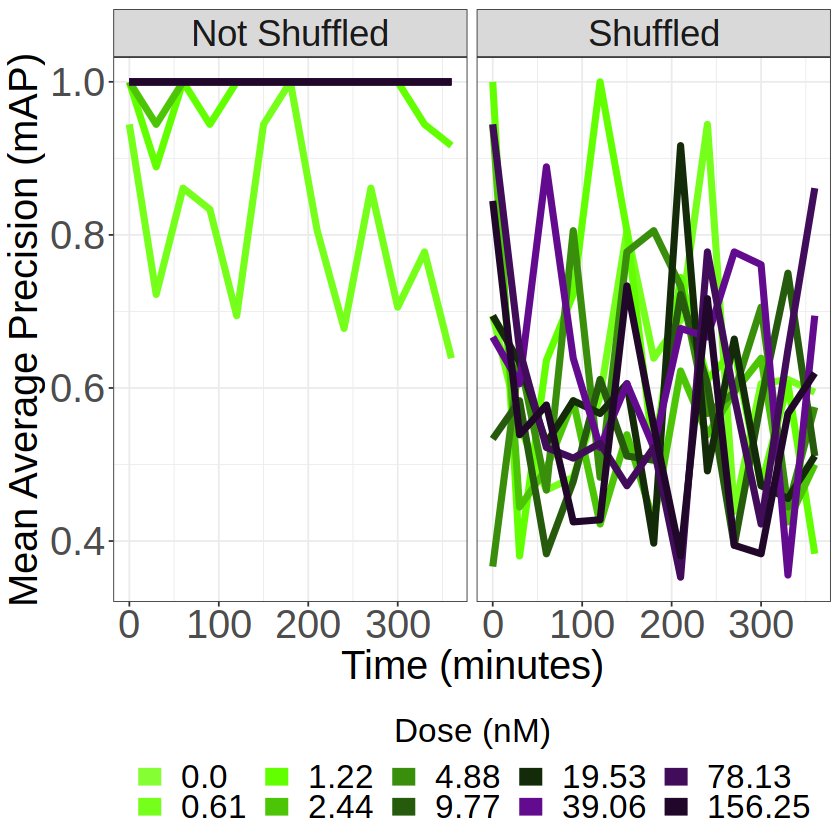

In [7]:
mAP_plot <- (
    ggplot(data = mAP_df, aes(x = Metadata_Time, y = mean_average_precision))
    + geom_line(aes(color = Metadata_dose), size = 2)
    + facet_wrap(Shuffle~.)
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (minutes)",
        y = "Mean Average Precision (mAP)",
        color = "Dose (nM)",
    )
    
    # change the legend title
    + guides(
        color = guide_legend(
            override.aes = list(size = 5),
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = font_size - 4 ),
            label.theme = element_text(size = font_size - 4),
            nrow = 2,
        ))
    + plot_themes

)
mAP_plot

In [8]:
umap_df$Metadata_dose_w_unit <- paste0(
    umap_df$Metadata_dose, 
    " nM"
)
umap_df$Metadata_dose_w_unit <- as.character(umap_df$Metadata_dose_w_unit)
umap_df$Metadata_dose_w_unit <- factor(
    umap_df$Metadata_dose_w_unit, 
    levels = c(
        '0.0 nM',
        '0.61 nM',
        '1.22 nM',
        '2.44 nM',
        '4.88 nM',
        '9.77 nM',
        '19.53 nM',
        '39.06 nM',
        '78.13 nM',
        '156.25 nM'
    )
)

In [9]:
temporal_palette <- c(
    "#008CF5", "#0079E7", "#0066D9", "#0053CB", "#0040BD", "#002D9F", "#001A91", "#000781", "#000570", "#000460", "#000350", "#000240", "#000130"
)

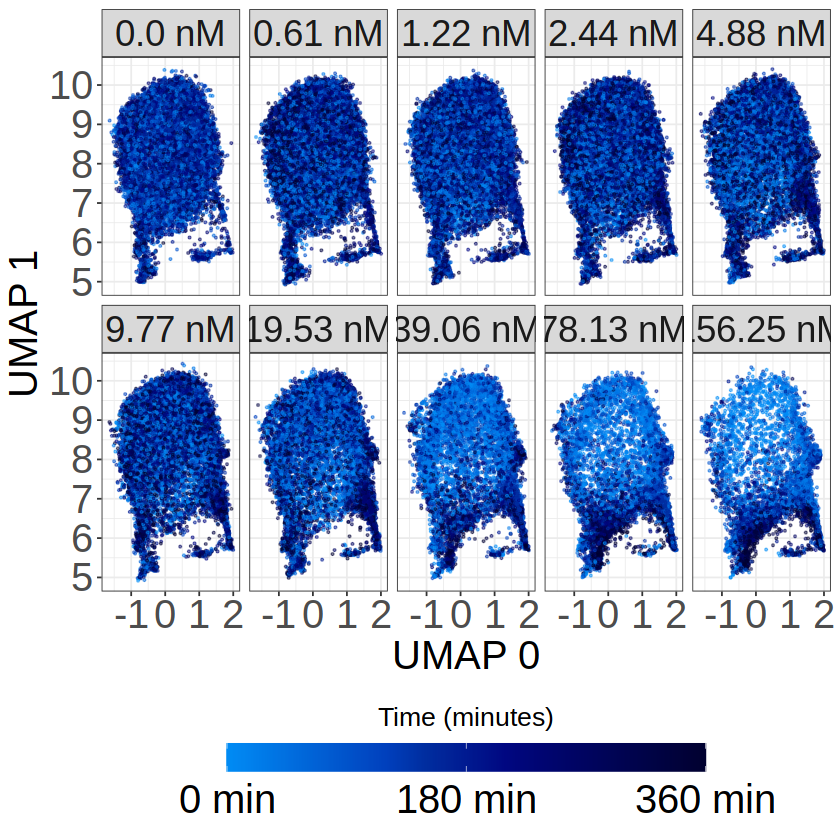

In [10]:
umap_df$Metadata_Time <- as.numeric(umap_df$Metadata_Time)
umap_plot_facet <- (
    ggplot(data = umap_df, aes(x = UMAP_0, y = UMAP_1))
    + geom_point(aes(color = Metadata_Time), size = 0.5, alpha = 0.5)
    + scale_color_gradientn(
        colors = temporal_palette,
        breaks = c(0, 180, 360), # breaks at 0, 90, and 360 minutes
        labels = c("0 min", "180 min", "360 min")
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Time (minutes)",
    )
    + facet_wrap(Metadata_dose_w_unit~., nrow = 2)
    + guides(
        color = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 16),
            # make the legend longer 
            barwidth = 20,
        ))
    + plot_themes
    )
umap_plot_facet

In [11]:
# set temporal colour palette of 13 hues of blue
temporal_palette <- c(
    "#008CF5", "#0079E7", "#0066D9", "#0053CB", "#0040BD", "#002D9F", "#001A91", "#000781", "#000570", "#000460", "#000350", "#000240", "#000130"
)
# calculate the centroid of each UMAP cluster dose and time wise
umap_df_centroids <- umap_df %>% group_by(Metadata_dose, Metadata_Time) %>% summarise(
    UMAP0_centroid = mean(UMAP_0),
    UMAP1_centroid = mean(UMAP_1)
)
umap_df_centroids$Metadata_Time <- as.numeric(gsub(" min", "", umap_df_centroids$Metadata_Time))
umap_df_centroids$Metadata_dose_w_unit <- paste0(
    umap_df_centroids$Metadata_dose, 
    " nM"
)
umap_df_centroids$Metadata_dose_w_unit <- as.character(umap_df_centroids$Metadata_dose_w_unit)
umap_df_centroids$Metadata_dose_w_unit <- factor(
    umap_df_centroids$Metadata_dose_w_unit, 
    levels = c(
        '0.0 nM',
        '0.61 nM',
        '1.22 nM',
        '2.44 nM',
        '4.88 nM',
        '9.77 nM',
        '19.53 nM',
        '39.06 nM',
        '78.13 nM',
        '156.25 nM'
    )
)

`summarise()` has grouped output by 'Metadata_dose'. You can override using the
`.groups` argument.


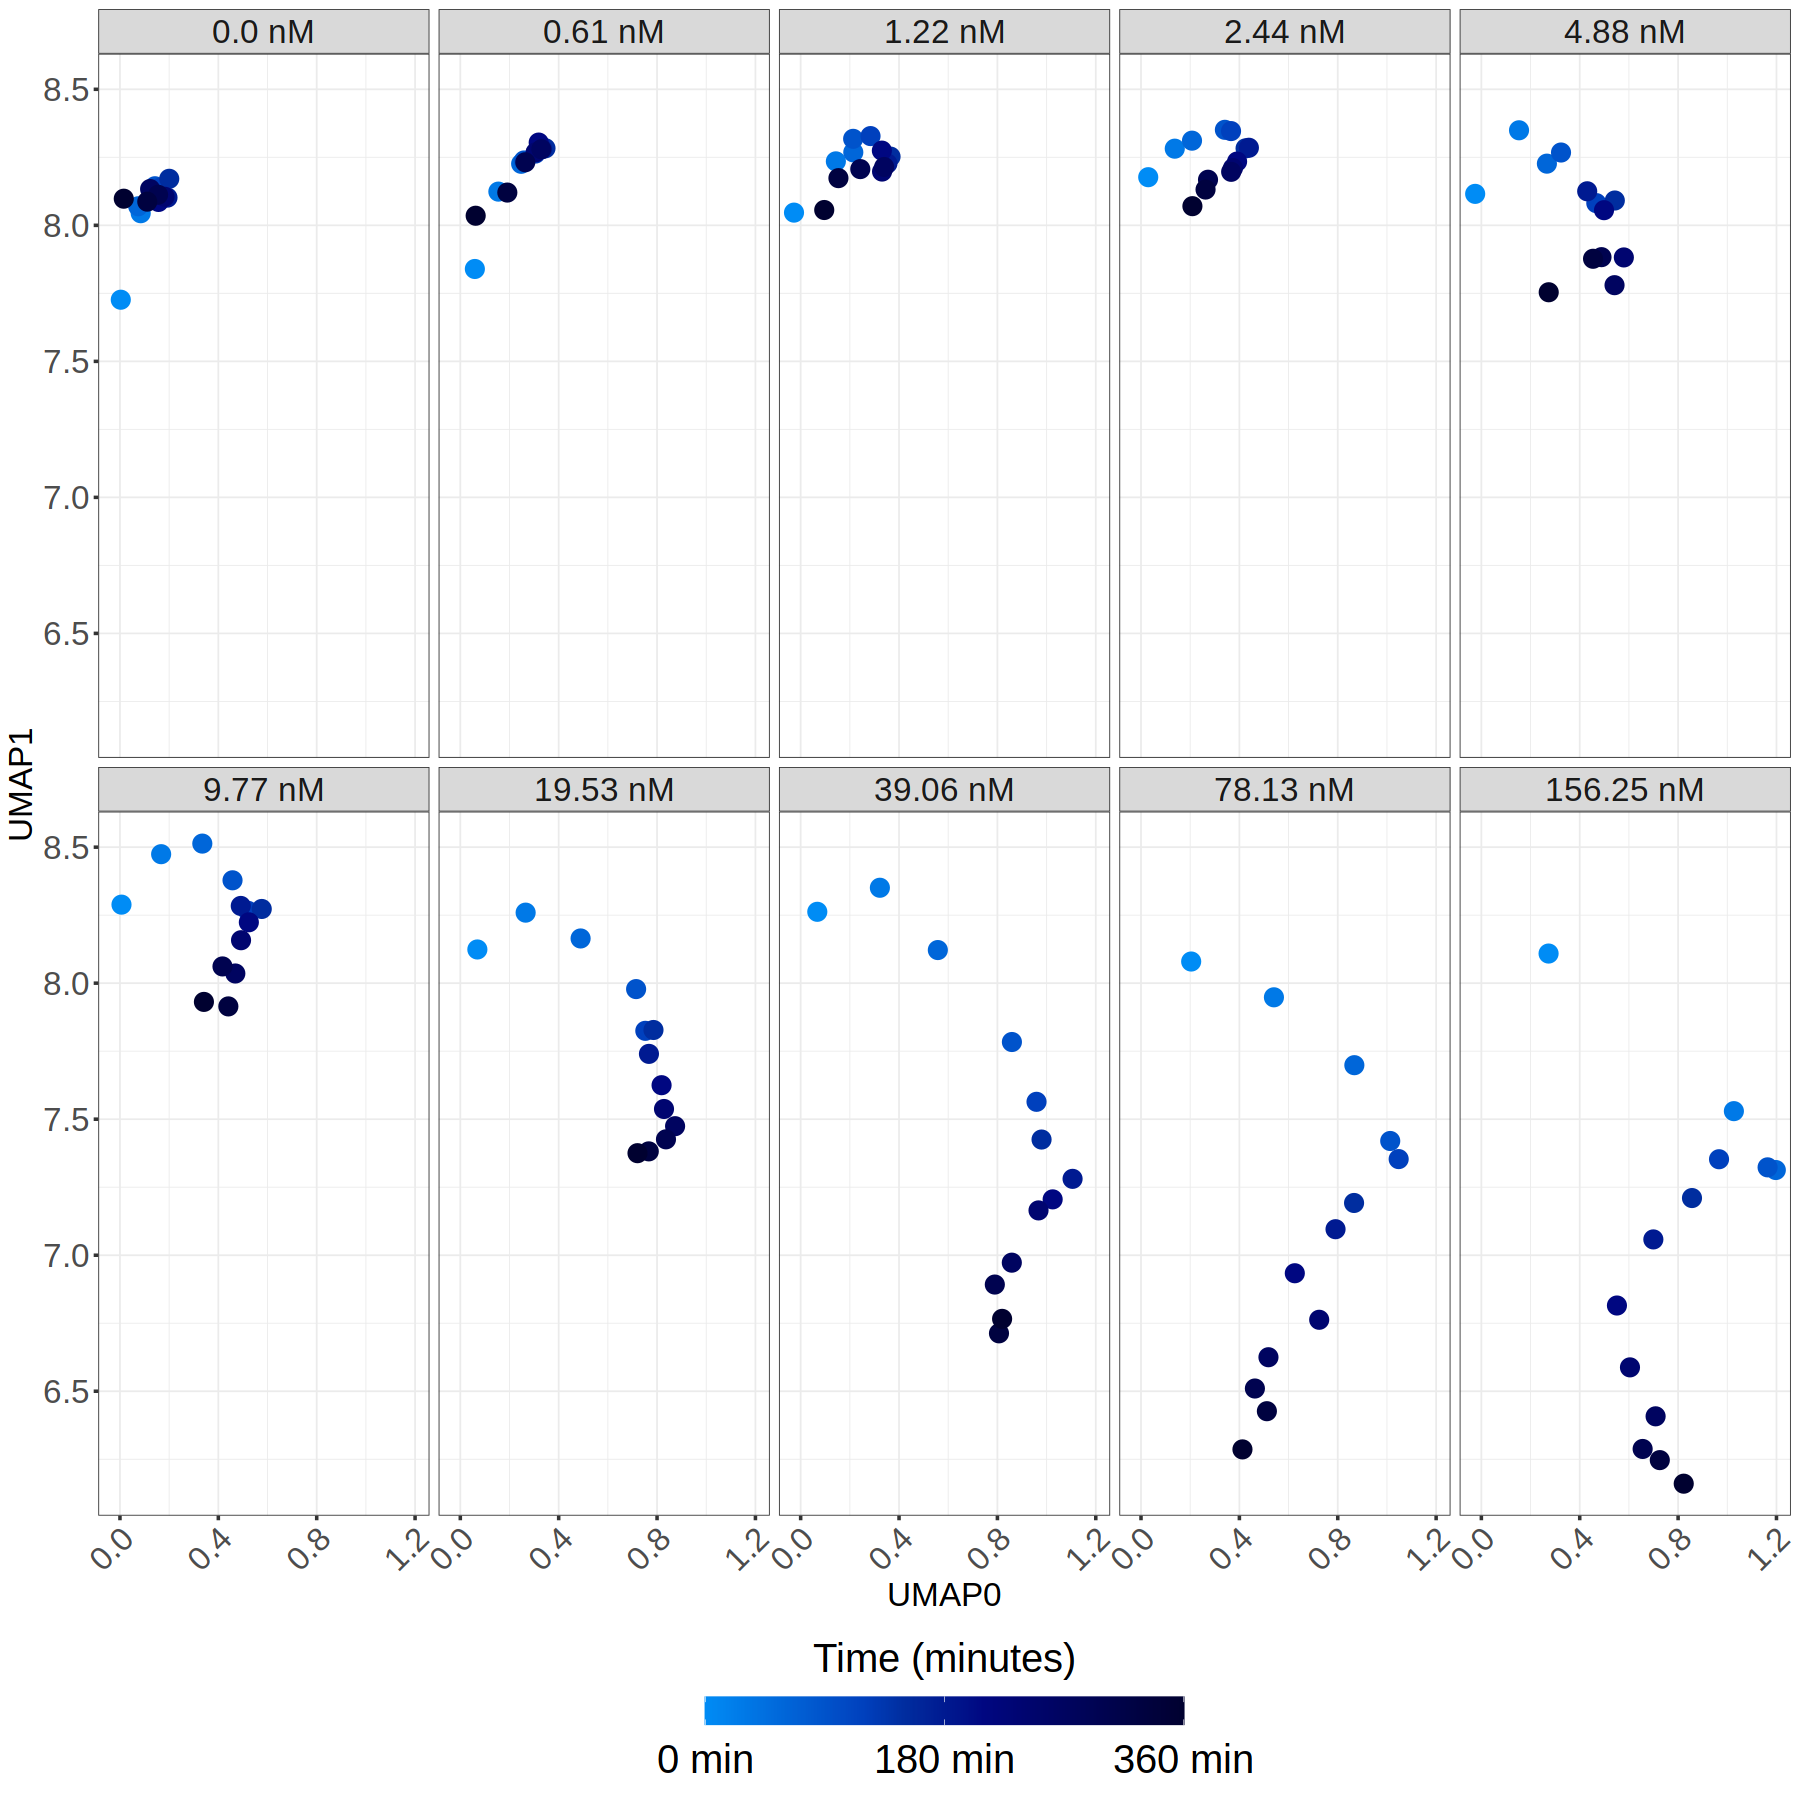

In [12]:

width <- 15
height <- 15
options(repr.plot.width = width, repr.plot.height = height)
# plot the centroids per dose over time
umap_centroid_plot <- (
    ggplot(data = umap_df_centroids, aes(x = UMAP0_centroid, y = UMAP1_centroid, color = Metadata_Time))
    + geom_point(size = 5)
    + theme_bw()
    + labs( x = "UMAP0", y = "UMAP1")
    # add custom colors
    + scale_color_gradientn(
        colors = temporal_palette,

        breaks = c(0, 180, 360), # breaks at 0, 90, and 360 minutes
        labels = c("0 min", "180 min", "360 min"),
        name = "Time (minutes)",
        guide = guide_colorbar(
            title.position = "top",
            title.hjust = 0.5,
            title.theme = element_text(size = 24),
            # make the legend longer 
            barwidth = 20
        )
    )
    + theme(
        strip.text.x = element_text(size = 20),
        strip.text.y = element_text(size = 20),
        axis.text.x = element_text(size = 20, angle = 45, hjust = 1),
        axis.text.y = element_text(size = 20),
        axis.title.x = element_text(size = 20),
        axis.title.y = element_text(size = 20),
        axis.ticks.x = element_line(size = 1),
        axis.ticks.y = element_line(size = 1),
        legend.text = element_text(size = 24),
        legend.position = "bottom",
        legend.title = element_text(size = 24, hjust = 0.5),
        plot.title = element_text(size = 24, hjust = 0.5)
        )
    + facet_wrap(~Metadata_dose_w_unit,nrow = 2)
    
)
umap_centroid_plot


# Plot cell count over time

In [13]:
# get the well from the well_fov column, get the first part of the string
# before the underscore and number
cell_count_df$well <- sub("_.*", "", cell_count_df$well_fov)
# map the well to the dose from the mAP_df
well_dose_df <- umap_df %>%
    select(well = Metadata_Well, dose = Metadata_dose) %>%
    distinct()
# map the well to the dose in the cell_count_df
cell_count_df <- cell_count_df %>%
    left_join(well_dose_df, by = "well") 
# rename dose to Metadata_dose
cell_count_df <- cell_count_df %>%
    rename(Metadata_dose = dose) %>%
    rename(Metadata_Well = well) 
cell_count_df$Metadata_dose <- as.character(cell_count_df$Metadata_dose)
cell_count_df$Metadata_dose <- factor(
    cell_count_df$Metadata_dose, 
    levels = c(
        '0.0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)

In [14]:
# get the counts of cells per timepoint per well
cell_count_df <- cell_count_df %>% 
    group_by(Metadata_time, Metadata_Well, Metadata_dose) %>%
    summarise(
        cell_count = sum(total_CP_cells),
        .groups = "drop"
    )

In [15]:
# normalize each well's cell count to the first timepoint
cell_count_norm_df <- cell_count_df %>%
    group_by(Metadata_Well, Metadata_dose) %>%
    mutate(
        cell_count_norm = cell_count / cell_count[Metadata_time == 0]
    ) %>%
    ungroup()


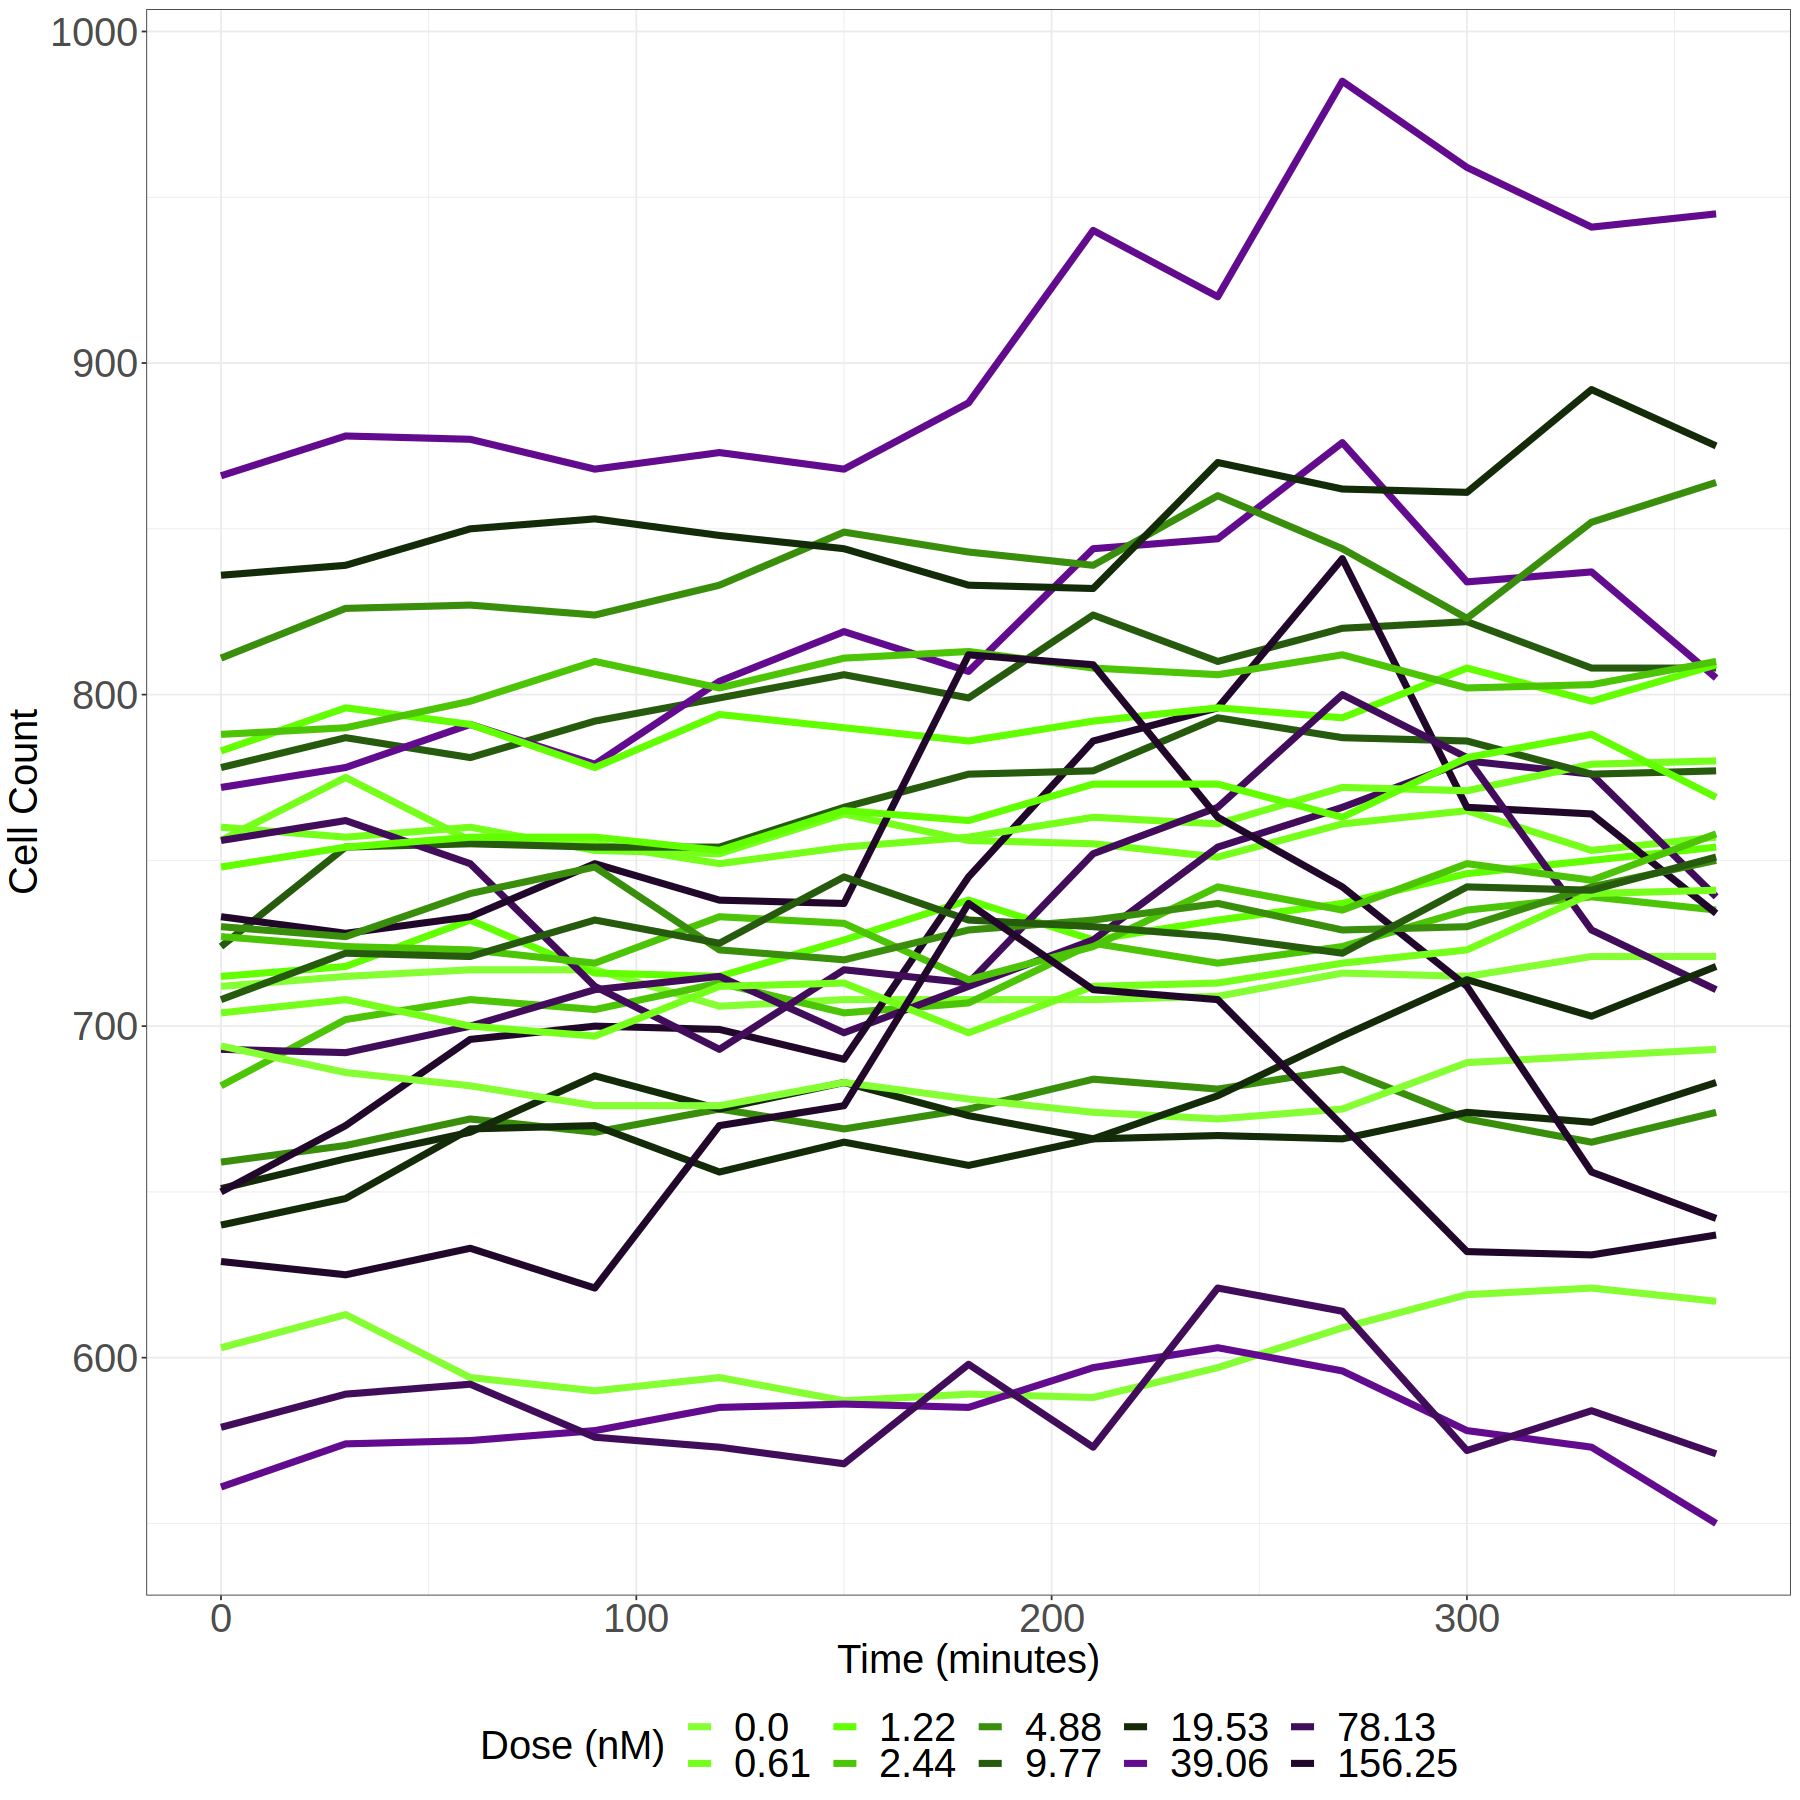

In [16]:
cell_count_v_time_plot_colored_by_dose <- (
    ggplot(data = cell_count_df, aes(x = Metadata_time, y = cell_count))
    + geom_line(aes(group = Metadata_Well,color = Metadata_dose), size = 2)
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (minutes)",
        y = "Cell Count",
        color = "Dose (nM)",
    )
    + plot_themes

)
cell_count_v_time_plot_colored_by_dose

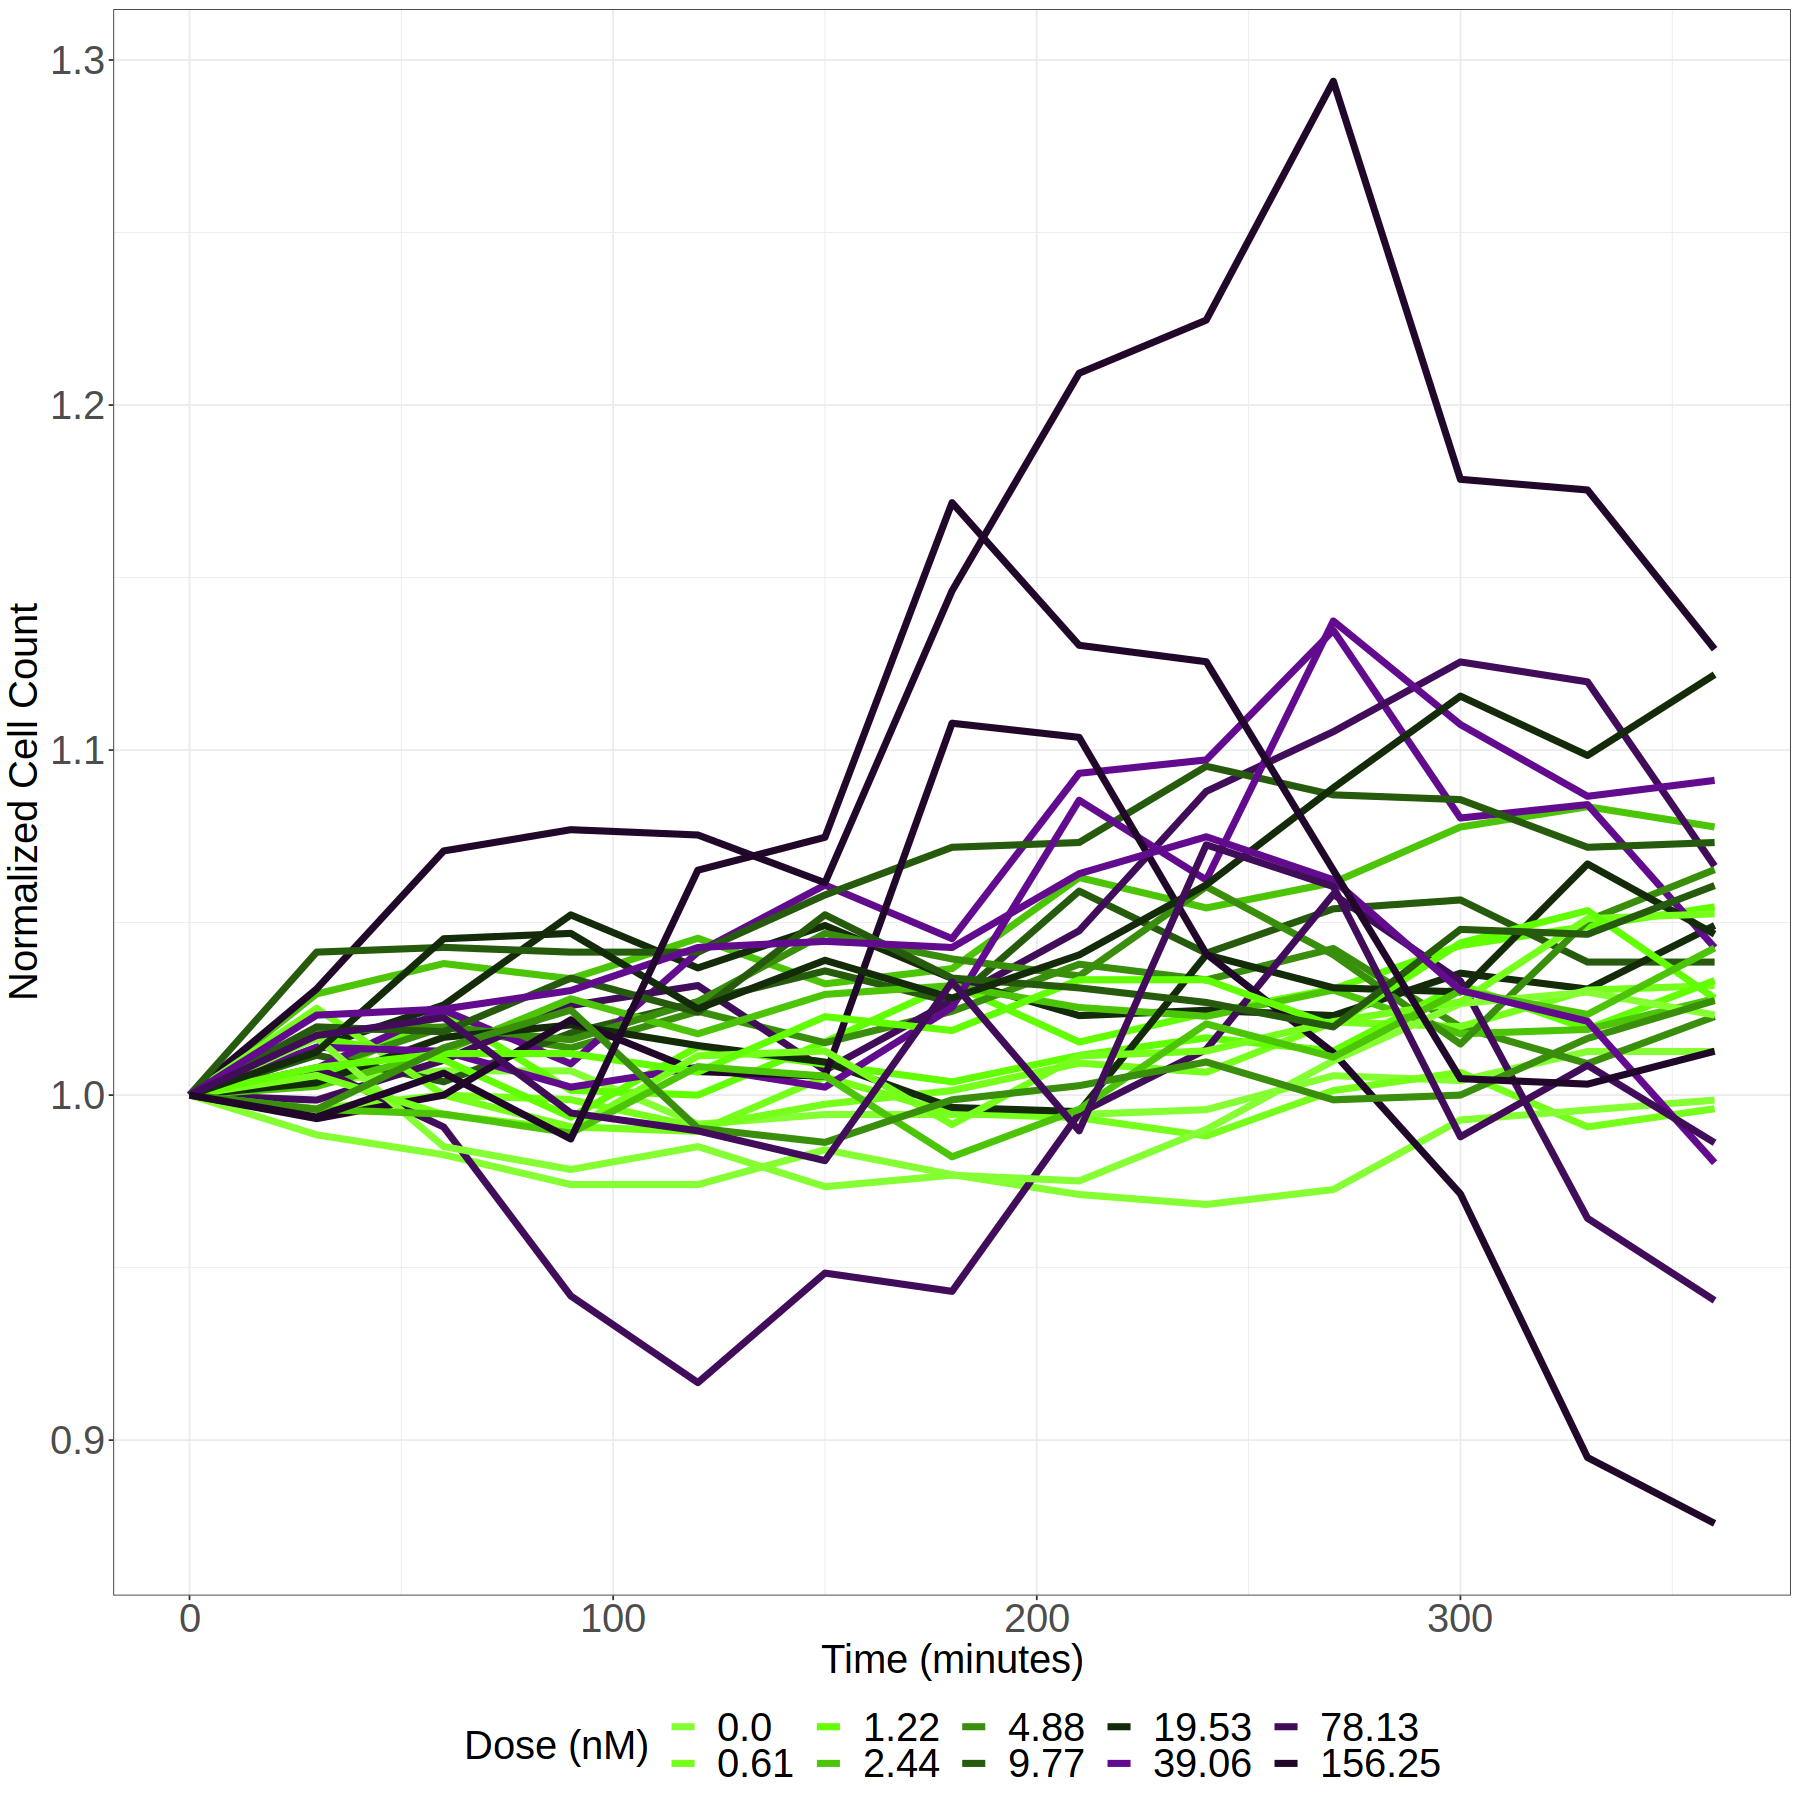

In [17]:
normalized_cell_count_v_time_plot_colored_by_dose <- (
    ggplot(data = cell_count_norm_df, aes(x = Metadata_time, y = cell_count_norm))
    + geom_line(aes(group = Metadata_Well,color = Metadata_dose), size = 2)
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (minutes)",
        y = "Normalized Cell Count",
        color = "Dose (nM)",
    )
    + plot_themes

)
normalized_cell_count_v_time_plot_colored_by_dose

# Assemble all plots into a single figure

In [18]:
cell_count_v_time_plot_colored_by_dose <- cell_count_v_time_plot_colored_by_dose + theme(legend.position = "none")
normalized_cell_count_v_time_plot_colored_by_dose <- normalized_cell_count_v_time_plot_colored_by_dose + theme(legend.position = "none")

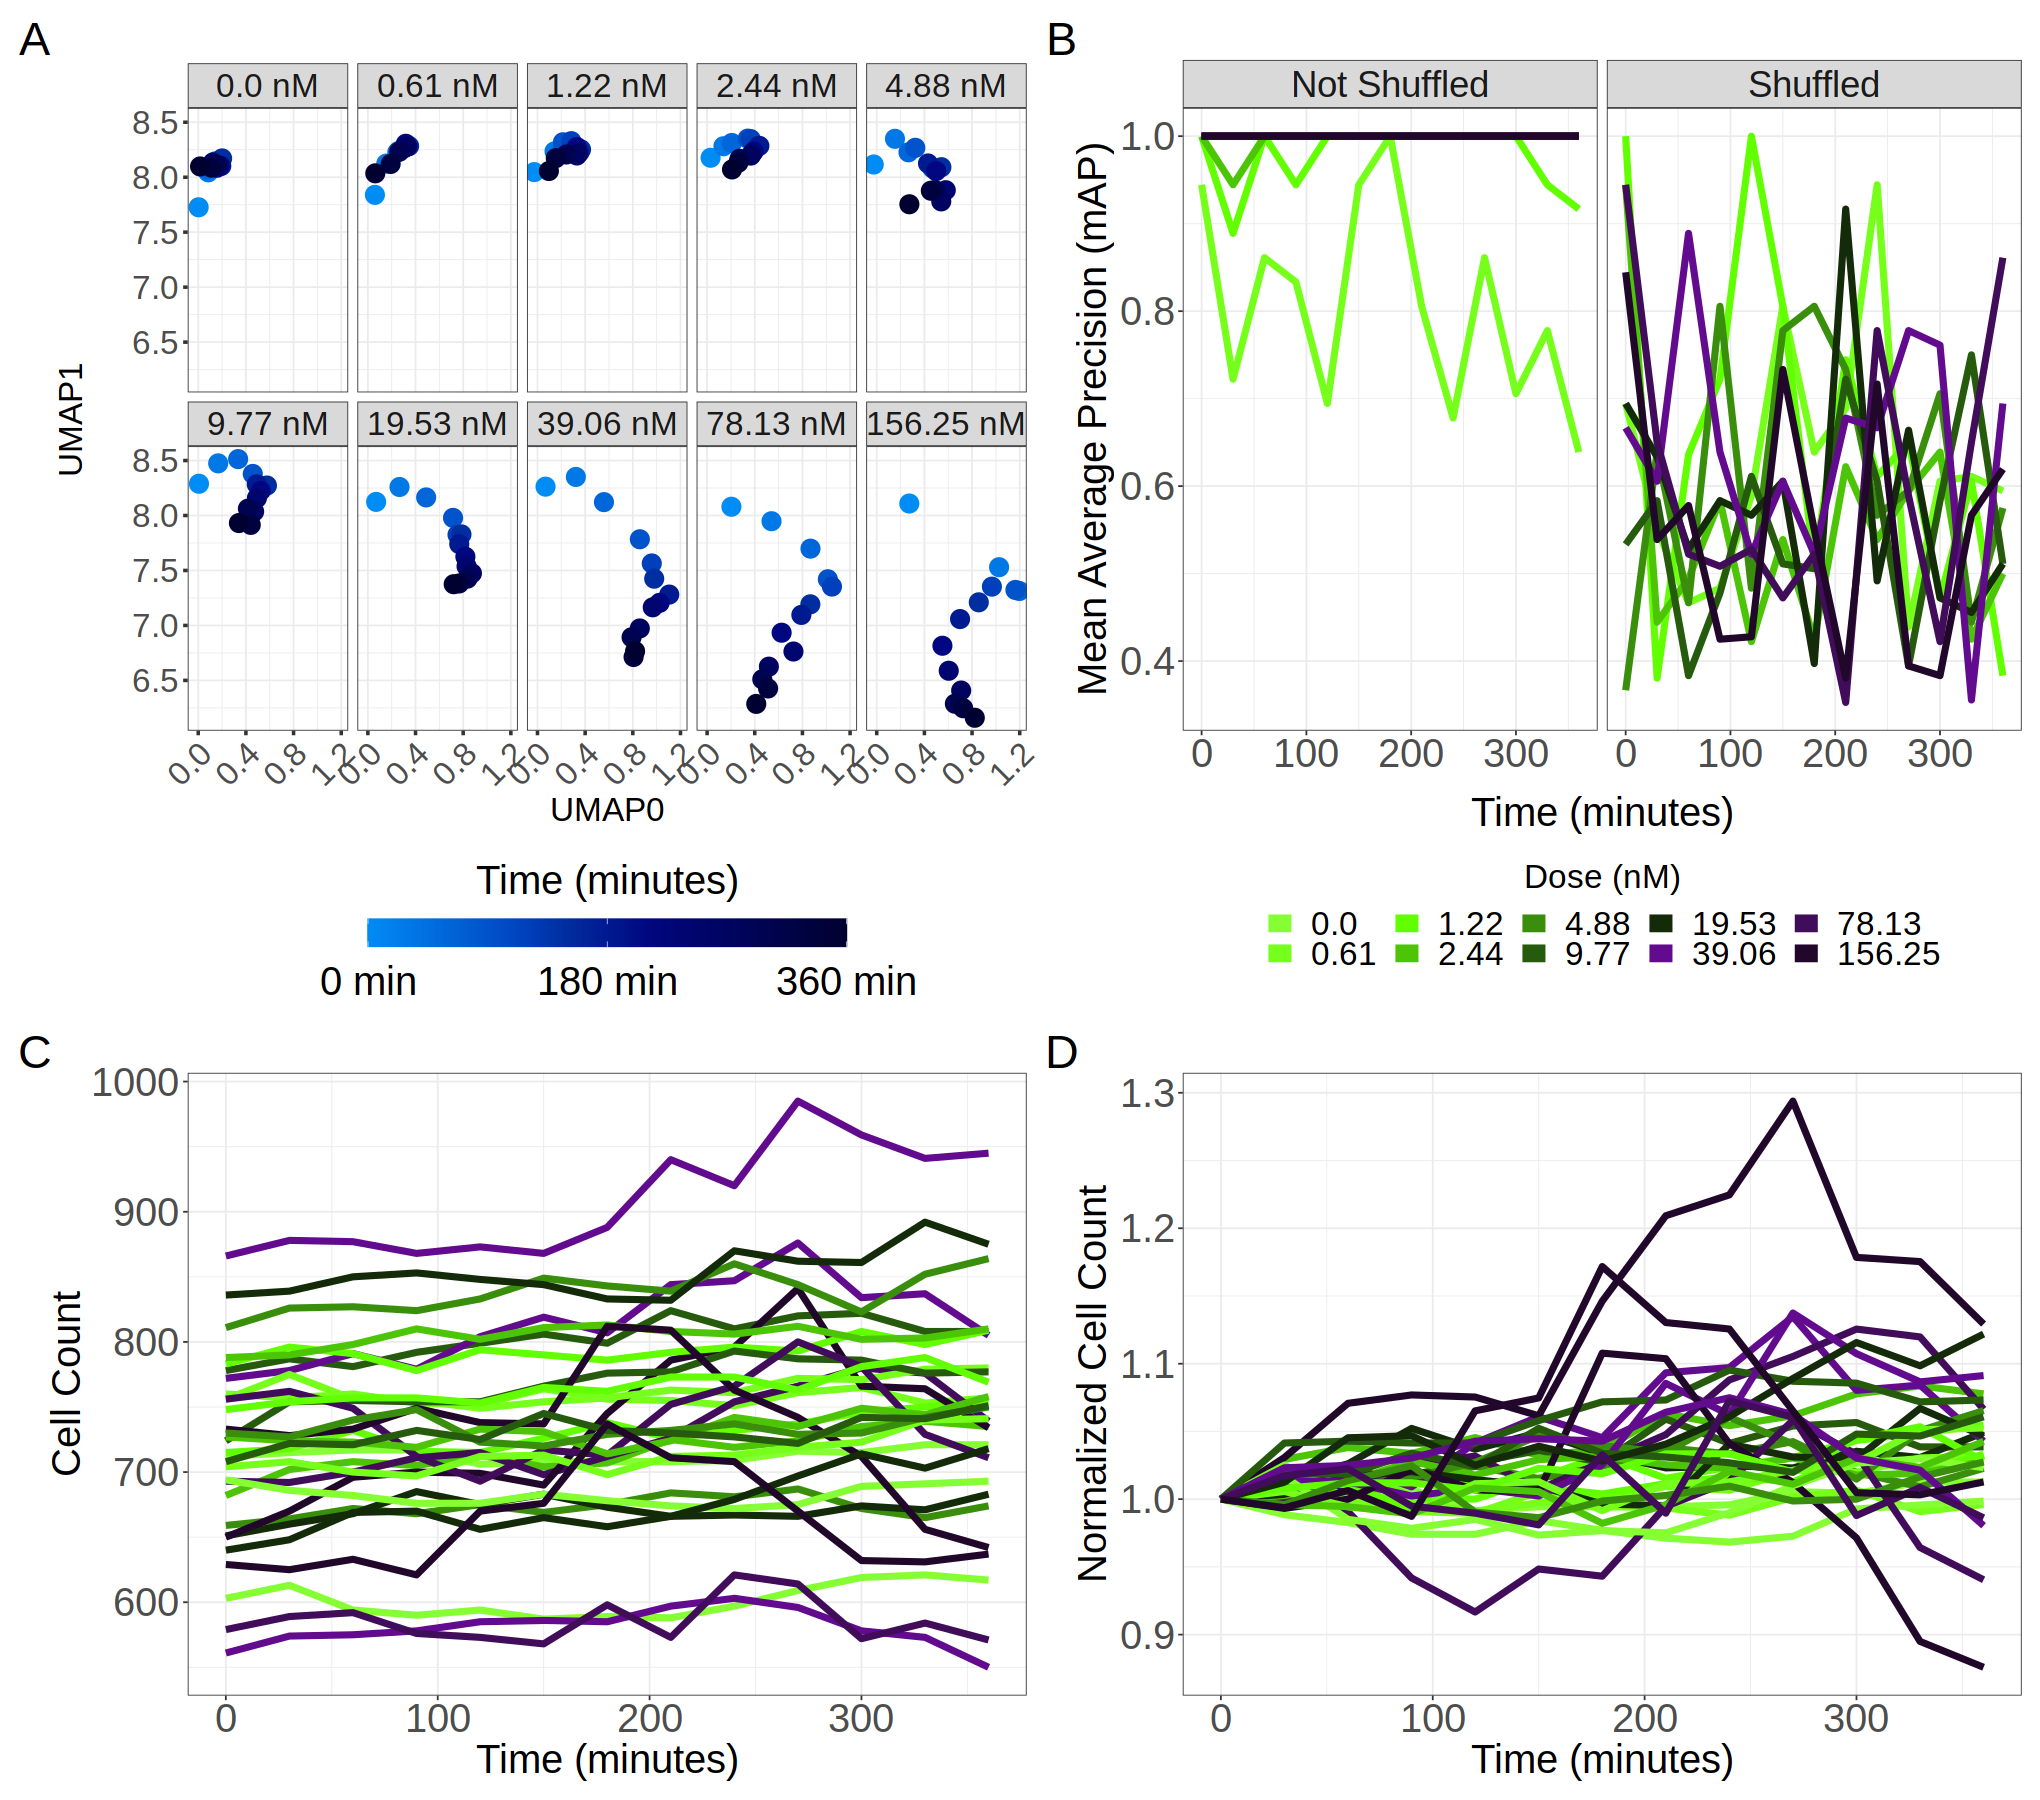

In [19]:
width <- 17
height <- 15
options(repr.plot.width=width, repr.plot.height=height)
layout <- c(
    area(t=1, b=1, l=1, r=2), # A
    area(t=1, b=1, l=3, r=4), # B
    area(t=2, b=2, l=1, r=2), # C
    area(t=2, b=2, l=3, r=4) # D
)
metric_v_time_final_plot <- (
    umap_centroid_plot
    + mAP_plot
    
    + cell_count_v_time_plot_colored_by_dose
    + normalized_cell_count_v_time_plot_colored_by_dose
    
    + plot_layout(design = layout, widths = c(0.6, 1))
    # make bottom plot not align
    + plot_annotation(tag_levels = 'A') & theme(plot.tag = element_text(size = 28))
)
ggsave(
    filename = final_figure_path,
    plot = metric_v_time_final_plot,
    width = width,
    height = height,
    dpi = 600
)
metric_v_time_final_plot